<a href="https://colab.research.google.com/github/chriswmann/r-east-midlands-house-price-analysis/blob/master/house_price_analysis_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
install.packages(c("visdat", "pushoverr"))
library(visdat)
library(pushoverr)
library(tidyverse)
options(repr.plot.width = 6, repr.plot.height = 4)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [0]:
pushover_user_key = "u1mc9ppiv3ytgxbut174vj4ow293e8"
pushover_api_key = "a81n1712637qown5kbps4ze2d3m1f6"

In [0]:
set_pushover_user(user = pushover_user_key)
set_pushover_app(token = pushover_api_key)

In [0]:
top_and_tail <- function(df) {
    # Return the head and tail of a dataframe.
    print(head(df))
    print(tail(df))
}

In [0]:
data_url <- "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv"

In [0]:
column_names <- c("ID",
                  "Price_GBP",
                  "Date_of_Transfer",
                  "Postcode",
                  "Property_Type",
                  "Old_or_New",
                  "Duration",
                  "PAON",
                  "SAON",
                  "Street",
                  "Locality",
                  "Town_City",
                  "District",
                  "County",
                  "PPDCategory_Type",
                  "Add_Change_Del")

In [0]:
raw_ppd <- read_csv(data_url, col_names = F)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_datetime(format = ""),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_character(),
  X15 = col_character(),
  X16 = col_character()
)


In [0]:
# pushover_emergency(message = "CSV Read Complete")

In [0]:
names(raw_ppd) <- column_names

In [0]:
head(raw_ppd)

ID,Price_GBP,Date_of_Transfer,Postcode,Property_Type,Old_or_New,Duration,PAON,SAON,Street,Locality,Town_City,District,County,PPDCategory_Type,Add_Change_Del
{D5592EC2-8127-4D0B-81FA-BD6306BF6AB5},48000,1995-03-31,B97 6NJ,S,N,F,112,NA,FOXLYDIATE CRESCENT,REDDITCH,REDDITCH,REDDITCH,WORCESTERSHIRE,A,A
{DA9E3729-A1C3-4EF5-9DD2-BD632381A89F},23000,1995-10-20,LE10 2SE,F,N,L,30,NA,TILTON ROAD,BURBAGE,HINCKLEY,HINCKLEY AND BOSWORTH,LEICESTERSHIRE,A,A
{C8F270A4-B071-4CEB-BE3E-C0EAC816BF34},39500,1995-05-31,SS13 1NG,T,N,F,68,NA,PLUMLEYS,PITSEA,BASILDON,BASILDON,ESSEX,A,A
{9894201D-BAE7-4432-B8EB-C0EACD1C8C64},335000,1995-08-24,HA6 2TP,D,N,F,19,NA,COPSE WOOD WAY,NORTHWOOD,NORTHWOOD,HILLINGDON,GREATER LONDON,A,A
{AECD3A3E-3ADE-4B3F-90DD-B9E11C04769A},60000,1995-10-09,DL7 0SU,D,N,F,KEEPERS COTTAGE,NA,NA,KIRKBY FLEETHAM,NORTHALLERTON,HAMBLETON,NORTH YORKSHIRE,A,A
{9FE17499-3C2D-463F-9EAA-B9E12004C702},48000,1995-09-29,SS3 9YF,S,N,L,2,NA,CHAFFINCH CLOSE,SHOEBURYNESS,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A


At this point we will take a subset of the data, primarily based on my house buying criteria (price range, location property type etc.)  We will also include only data from 2000 onwards – this will therefore include some of the 'golden years' of house prices and also the Great Recession.

In [0]:
local_ppd <- raw_ppd %>%
                filter(Date_of_Transfer >= "2000-01-01",
                grepl('^NG|^DE|^LE', Postcode),
                Price_GBP < 2.5e5,
                Price_GBP > 1.5e5,
                Property_Type %in% c("D", "S"),
                Duration == 'F',
                PPDCategory_Type == "A",
                !County %in% c("NORTHAMPTONSHIRE", "STAFFORDSHIRE", "WARWICKSHIRE")) %>%
                select(Price_GBP,
                       Date_of_Transfer,
                       Postcode,
                       Property_Type,
                       Old_or_New,
                       Street,
                       Locality,
                       Town_City,
                       District,
                       County)

In [0]:
dim(local_ppd)

[1] 195173     10

I've tried various ways to do the next step, including one which was clever (convert to a data.frame in order to get alternating results from strsplit) but this seems to be the fastest.

In [0]:
local_ppd$Outcode <- sapply(strsplit(local_ppd$Postcode, " "), "[[", 1)

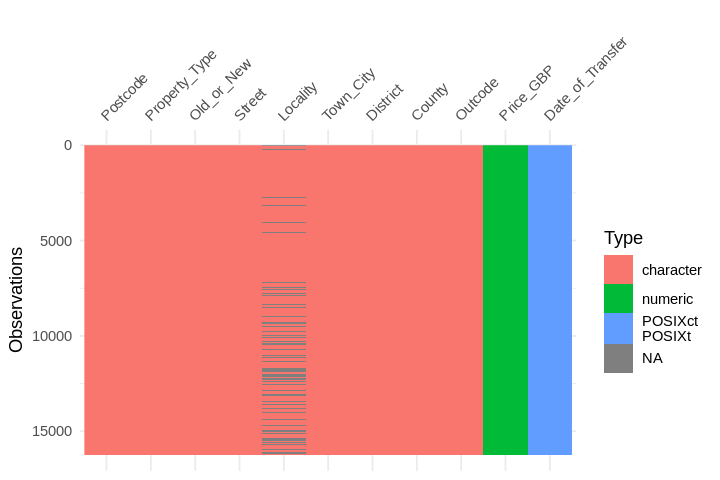

In [0]:
vis_dat(local_ppd[seq(1, dim(local_ppd)[1], 12), ])

We'll do a little formatting and, also, filter where there are a minimum of five properties per month and postcode.  (I used this in an earlier version of the notebook where I didn't remove properties in Warwickshire, Northamptonshire and Staffordshire until later.  I think I picked up a couple of properties here and there which were in different counties whilst having outward postcodes in my areas.  The upshot is that the filter may no longer be necessary at this point so I should test it and remove it if possible.)

In [0]:
local_summary_ppd <- local_ppd %>%
    mutate(Year = strftime(Date_of_Transfer, format = "%Y"),
    Month = strftime(Date_of_Transfer, format = "%m")) %>%
    group_by(County, Postcode, Year, Month) %>%
    filter(n() > 5) %>%
    summarise(Median_Price = median(Price_GBP),
              Trimmed_Mean_Price = mean(Price_GBP, 0.1))
local_summary_ppd$County <- as.factor(local_summary_ppd$County)
local_summary_ppd$Postcode <- as.factor(local_summary_ppd$Postcode)
local_summary_ppd$Year <- as.numeric(local_summary_ppd$Year)
local_summary_ppd$Month <- as.numeric(local_summary_ppd$Month)
top_and_tail(local_summary_ppd)
str(local_summary_ppd)

# A tibble: 6 x 6
# Groups:   County, Postcode, Year [6]
  County        Postcode  Year Month Median_Price Trimmed_Mean_Price
  <fct>         <fct>    <dbl> <dbl>        <dbl>              <dbl>
1 CITY OF DERBY DE22 3XT  2018     6      165995             187424.
2 CITY OF DERBY DE22 4GW  2016     9      190995             198495 
3 CITY OF DERBY DE22 4JL  2015     6      180998.            185872.
4 CITY OF DERBY DE22 4NW  2016     6      184950             196379.
5 CITY OF DERBY DE23 3ZA  2006    10      198000             199107.
6 CITY OF DERBY DE3 0DQ   2001    10      231950             223321.
# A tibble: 6 x 6
# Groups:   County, Postcode, Year [6]
  County          Postcode  Year Month Median_Price Trimmed_Mean_Price
  <fct>           <fct>    <dbl> <dbl>        <dbl>              <dbl>
1 NOTTINGHAMSHIRE NG24 3UL  2012     6      179495             193246.
2 NOTTINGHAMSHIRE NG5 8RN   2014     6      245548.            235180 
3 NOTTINGHAMSHIRE NG5 8TY   2012     1      184975

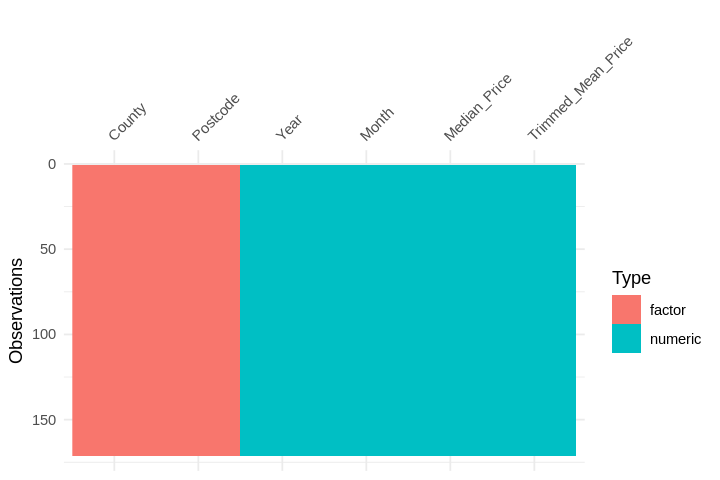

In [0]:
vis_dat(local_summary_ppd)

In [0]:
unique(local_summary_ppd$County)

[1] CITY OF DERBY      CITY OF NOTTINGHAM DERBYSHIRE         LEICESTER         
[5] LEICESTERSHIRE     LINCOLNSHIRE       NOTTINGHAMSHIRE    RUTLAND           
8 Levels: CITY OF DERBY CITY OF NOTTINGHAM DERBYSHIRE ... RUTLAND

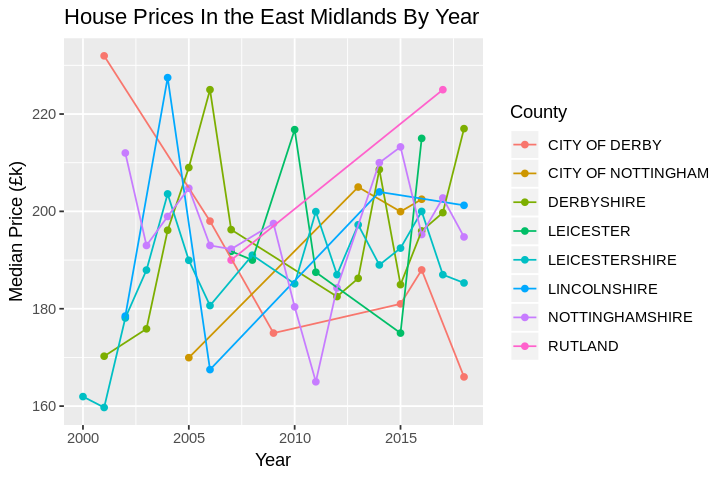

In [0]:
plot_price_by_year <- ggplot(local_summary_ppd, aes(x = Year, y = Median_Price, colour = County)) +
                 geom_point(stat='summary', fun.y=median) +
                 stat_summary(fun.y=median, geom="line") +
                 scale_y_continuous(labels = function(x) format(x / 1000)) +
                 labs(x = "Year", y = "Median Price (£k)", title = "House Prices In the East Midlands By Year")
plot_price_by_year

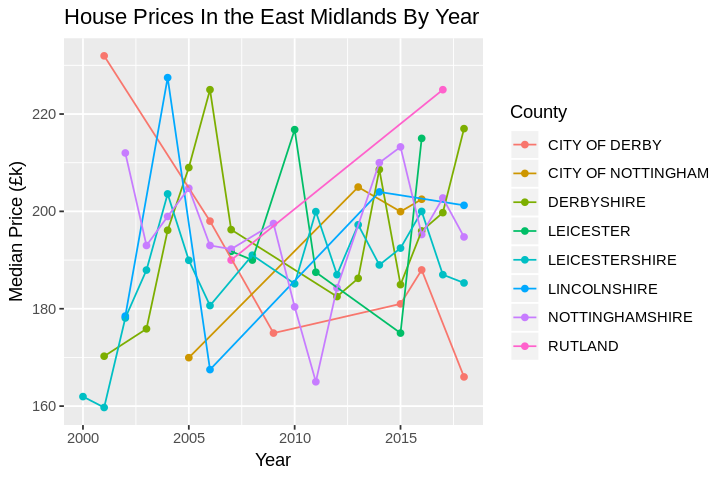

In [0]:
plot_price_by_year <- ggplot(local_summary_ppd, aes(x = Year, y = Median_Price, colour = County)) +
                 geom_point(stat='summary', fun.y=median) +
                 stat_summary(fun.y=median, geom="line") +
                 scale_y_continuous(labels = function(x) format(x / 1000)) +
                 labs(x = "Year", y = "Median Price (£k)", title = "House Prices In the East Midlands By Year")
plot_price_by_year

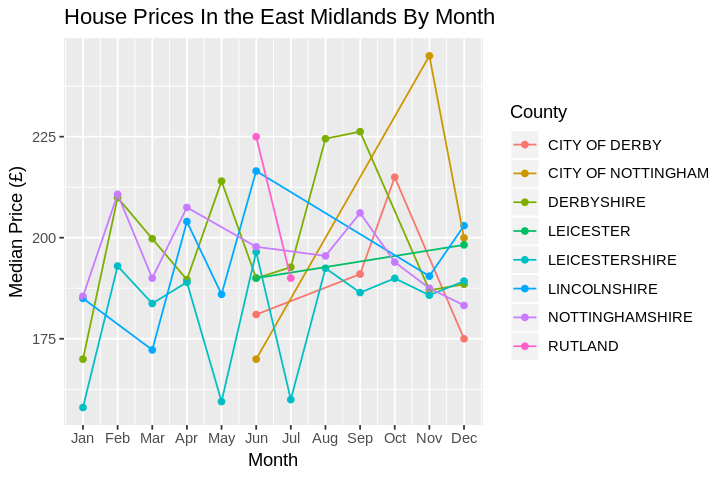

In [0]:
plot_price_by_month <- ggplot(local_summary_ppd, aes(x = Month, y = Median_Price, colour = County)) +
    geom_point(stat='summary', fun.y=median) +
    stat_summary(fun.y=median, geom="line") +
    scale_y_continuous(labels = function(x) format(x / 1000)) +
    scale_x_continuous(breaks = seq(1, 12, 1), labels = month.abb[seq(1, 12, 1)], limits = c(1, 12)) +
    labs(x = "Month", y = "Median Price (£)", title = "House Prices In the East Midlands By Month")
plot_price_by_month

The monthly price breakdown isn't overly useful to me.  The yearly breakdown is though.
The median price in Derby and Nottingham has fallen in the last two years.

The median price in Rutland appears to have fallen continuously since 2015.
This struck me as odd.  Having grown up there, I know the area very well, and my expectation was that prices would have risen.  I thought perhaps more affordable homes had been built (the rate of housebuilding has certainly been high from what I can see on my visits there.)

However, a quick bit of research confirms this observation is suspicious:
"Overall sold prices in Rutland over the last year were similar to the previous year and 8% up on the 2016 level of £298,327."
[Source](https://https://www.rightmove.co.uk/house-prices-in-Rutland.html).

Let's see what the trimmed mean looks like.

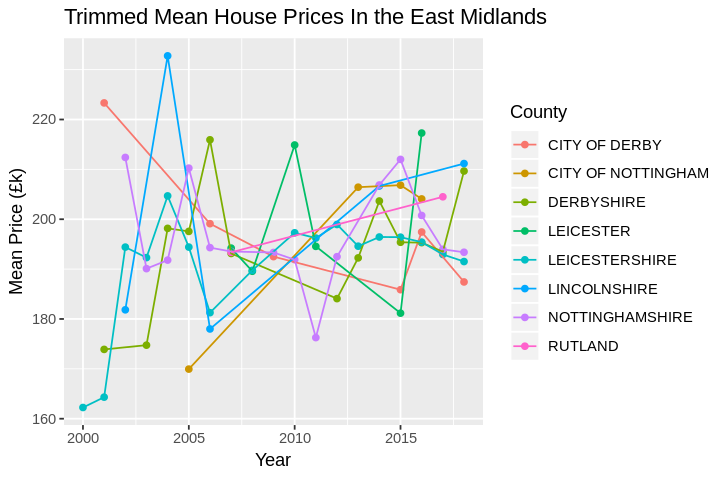

In [0]:
plot_price_by_year <- ggplot(local_summary_ppd, aes(x = Year, y = Trimmed_Mean_Price, colour = County)) +
                 geom_point(stat='summary', fun.y=mean) +
                 stat_summary(fun.y=mean, geom="line") +
                 scale_y_continuous(labels = function(x) format(x / 1000)) +
                 labs(x = "Year", y = "Mean Price (£k)", title = "Trimmed Mean House Prices In the East Midlands")
plot_price_by_year

We can definitely see something different going on in the plot.  Let's get the numeric values for the last two years of the data to see exactly what's happening.

In [0]:
install.packages('reshape')
library(reshape)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths



In [0]:
trimmed_mean_summary <- local_summary_ppd %>%
        filter(Year > 2015) %>%
        group_by(County, Year) %>%
        summarise(Price = mean(Trimmed_Mean_Price))
cast(trimmed_mean_summary, formula = County ~ Year, value = "Price")

County,2016,2017,2018
CITY OF DERBY,197436.8,NA,187423.6
CITY OF NOTTINGHAM,204068.3,NA,NA
DERBYSHIRE,195304.6,193478.8,209663.4
LEICESTER,217280.7,NA,NA
LEICESTERSHIRE,195403.0,192935.9,191514.2
LINCOLNSHIRE,NA,NA,211161.9
NOTTINGHAMSHIRE,200750.1,193961.6,193380.9
RUTLAND,NA,204495.0,NA


In [0]:
median_summary <- local_summary_ppd %>%
        filter(Year > 2015) %>%
        group_by(County, Year) %>%
        summarise(Price = median(Median_Price))
cast(median_summary, formula = County ~ Year, value = "Price")

County,2016,2017,2018
CITY OF DERBY,187972.5,NA,165995.0
CITY OF NOTTINGHAM,202495.0,NA,NA
DERBYSHIRE,195986.2,199737.5,216996.2
LEICESTER,214995.0,NA,NA
LEICESTERSHIRE,199995.0,186995.0,185297.5
LINCOLNSHIRE,NA,NA,201245.0
NOTTINGHAMSHIRE,195245.0,202750.0,194747.5
RUTLAND,NA,224995.0,NA


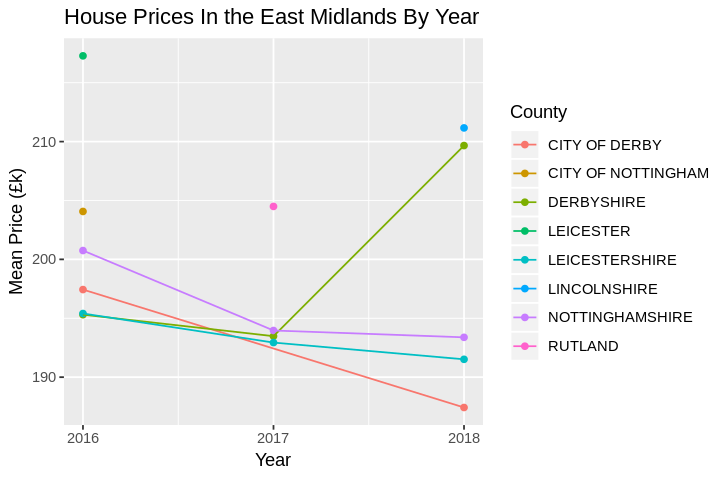

In [0]:
plot_price_by_year <- ggplot(trimmed_mean_summary, aes(x = Year, y = Price, colour = County)) +
                 geom_point(stat='summary', fun.y=mean) +
                 stat_summary(fun.y=mean, geom="line") +
                 scale_y_continuous(labels = function(x) format(x / 1000)) +
                 scale_x_continuous(breaks = seq(2016, 2018, 1), limits = c(2016, 2018)) +
                 labs(x = "Year", y = "Mean Price (£k)", title = "House Prices In the East Midlands By Year")
plot_price_by_year

In [0]:
install.packages("zoo")
library(zoo)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [0]:
local_summary_ppd$RM_Price <- c(mean(local_summary_ppd$Median_Price[1:2]),
                                rollmean(local_summary_ppd$Median_Price, 3),
                                mean(tail(local_summary_ppd$Median_Price, 2)))

In [0]:
top_and_tail(local_summary_ppd)

# A tibble: 6 x 7
# Groups:   County, Postcode, Year [6]
  County        Postcode  Year Month Median_Price Trimmed_Mean_Price RM_Price
  <fct>         <fct>    <dbl> <dbl>        <dbl>              <dbl>    <dbl>
1 CITY OF DERBY DE22 3XT  2018     6      165995             187424.  178495 
2 CITY OF DERBY DE22 4GW  2016     9      190995             198495   179329.
3 CITY OF DERBY DE22 4JL  2015     6      180998.            185872.  185648.
4 CITY OF DERBY DE22 4NW  2016     6      184950             196379.  187982.
5 CITY OF DERBY DE23 3ZA  2006    10      198000             199107.  204967.
6 CITY OF DERBY DE3 0DQ   2001    10      231950             223321.  201650 
# A tibble: 6 x 7
# Groups:   County, Postcode, Year [6]
  County          Postcode  Year Month Median_Price Trimmed_Mean_Price RM_Price
  <fct>           <fct>    <dbl> <dbl>        <dbl>              <dbl>    <dbl>
1 NOTTINGHAMSHIRE NG24 3UL  2012     6      179495             193246.  211679.
2 NOTTINGHAMSHIRE NG5 

In [0]:
local_summary_ppd <- local_summary_ppd %>%
                        group_by(Year) %>%
                        mutate(Annual_Price_Change = sum(Year) / 12)
top_and_tail(local_summary_ppd)

# A tibble: 6 x 8
# Groups:   Year [5]
  County Postcode  Year Month Median_Price Trimmed_Mean_Pr… RM_Price
  <fct>  <fct>    <dbl> <dbl>        <dbl>            <dbl>    <dbl>
1 CITY … DE22 3XT  2018     6      165995           187424.  178495 
2 CITY … DE22 4GW  2016     9      190995           198495   179329.
3 CITY … DE22 4JL  2015     6      180998.          185872.  185648.
4 CITY … DE22 4NW  2016     6      184950           196379.  187982.
5 CITY … DE23 3ZA  2006    10      198000           199107.  204967.
6 CITY … DE3 0DQ   2001    10      231950           223321.  201650 
# … with 1 more variable: Annual_Price_Change <dbl>
# A tibble: 6 x 8
# Groups:   Year [5]
  County Postcode  Year Month Median_Price Trimmed_Mean_Pr… RM_Price
  <fct>  <fct>    <dbl> <dbl>        <dbl>            <dbl>    <dbl>
1 NOTTI… NG24 3UL  2012     6      179495           193246.  211679.
2 NOTTI… NG5 8RN   2014     6      245548.          235180   203339.
3 NOTTI… NG5 8TY   2012     1      184975 

In [0]:
annual_price_change <- local_summary_ppd %>%
                           group_by(County, Year) %>%
                           summarise(Annual_Price_Change = mean(tail(Median_Price, 3)) - mean(head(Median_Price, 3)))
top_and_tail(annual_price_change)

# A tibble: 6 x 3
# Groups:   County [1]
  County         Year Annual_Price_Change
  <fct>         <dbl>               <dbl>
1 CITY OF DERBY  2001                   0
2 CITY OF DERBY  2006                   0
3 CITY OF DERBY  2009                   0
4 CITY OF DERBY  2015                   0
5 CITY OF DERBY  2016                   0
6 CITY OF DERBY  2018                   0
# A tibble: 6 x 3
# Groups:   County [2]
  County           Year Annual_Price_Change
  <fct>           <dbl>               <dbl>
1 NOTTINGHAMSHIRE  2015                  0 
2 NOTTINGHAMSHIRE  2016             -18842.
3 NOTTINGHAMSHIRE  2017              -6097.
4 NOTTINGHAMSHIRE  2018                  0 
5 RUTLAND          2007                  0 
6 RUTLAND          2017                  0 


Warning message:
“Removed 29 rows containing missing values (position_stack).”Warning message:
“Removed 7 rows containing missing values (geom_col).”

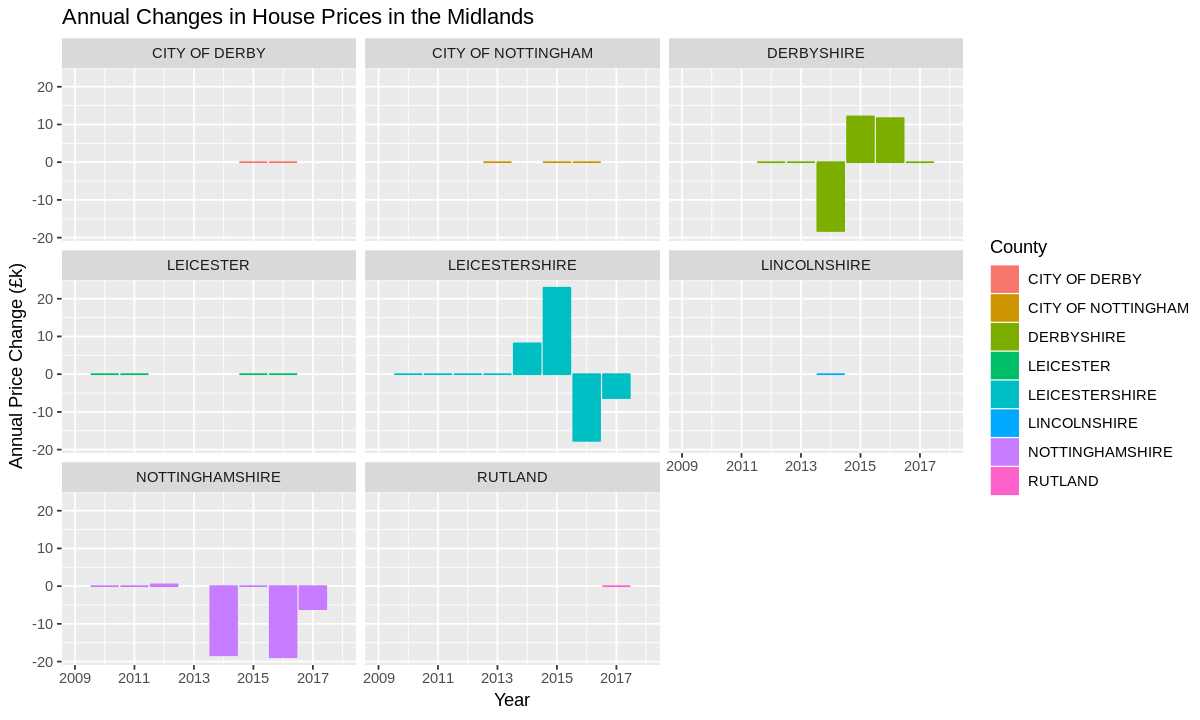

In [0]:
options(repr.plot.width = 10, repr.plot.height = 6)
plot_price_change_by_year <- ggplot(annual_price_change, aes(x = Year, y = Annual_Price_Change, colour = County, fill = County)) +
                            geom_col() +
                            scale_y_continuous(labels = function(x) format(x / 1000)) +
                            scale_x_continuous(breaks = seq(2009, 2017, 2), limits = c(2009, 2018)) +
                            facet_wrap(~County) +
                            labs(x = "Year", y = "Annual Price Change (£k)", title = "Annual Changes in House Prices in the Midlands")
plot_price_change_by_year
options(repr.plot.width = 6, repr.plot.height = 4)

Let's try normalising the data and plotting on a single set of axes.

In [0]:
east_mids_annual_price_change <- annual_price_change
min_price <- min(east_mids_annual_price_change$Annual_Price_Change)
max_price <- max(east_mids_annual_price_change$Annual_Price_Change)
east_mids_annual_price_change$Normalised_Price_Change <- 2 * (east_mids_annual_price_change$Annual_Price_Change - min_price) / (max_price - min_price) - 1

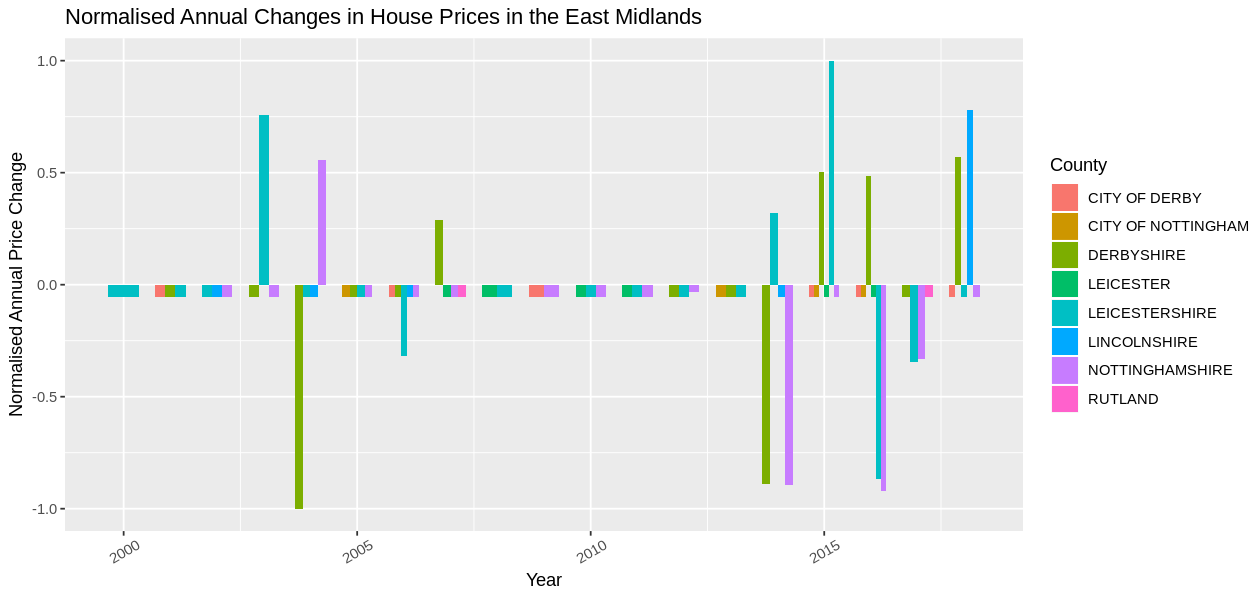

In [0]:
options(repr.plot.width = 10.5, repr.plot.height = 5)
plot_em_price_change_by_year <- ggplot(east_mids_annual_price_change, aes(x = Year, y = Normalised_Price_Change)) +
                            geom_col(aes(fill = County), position = "dodge", width = 0.65) +
                            labs(x = "Year", y = "Normalised Annual Price Change", title = "Normalised Annual Changes in House Prices in the East Midlands") +
                            theme(axis.text.x = element_text(angle = 30, vjust = 0.6))
plot_em_price_change_by_year
options(repr.plot.width = 6, repr.plot.height = 4)

In [0]:
# pushover_emergency(message = "Notebook run complete")

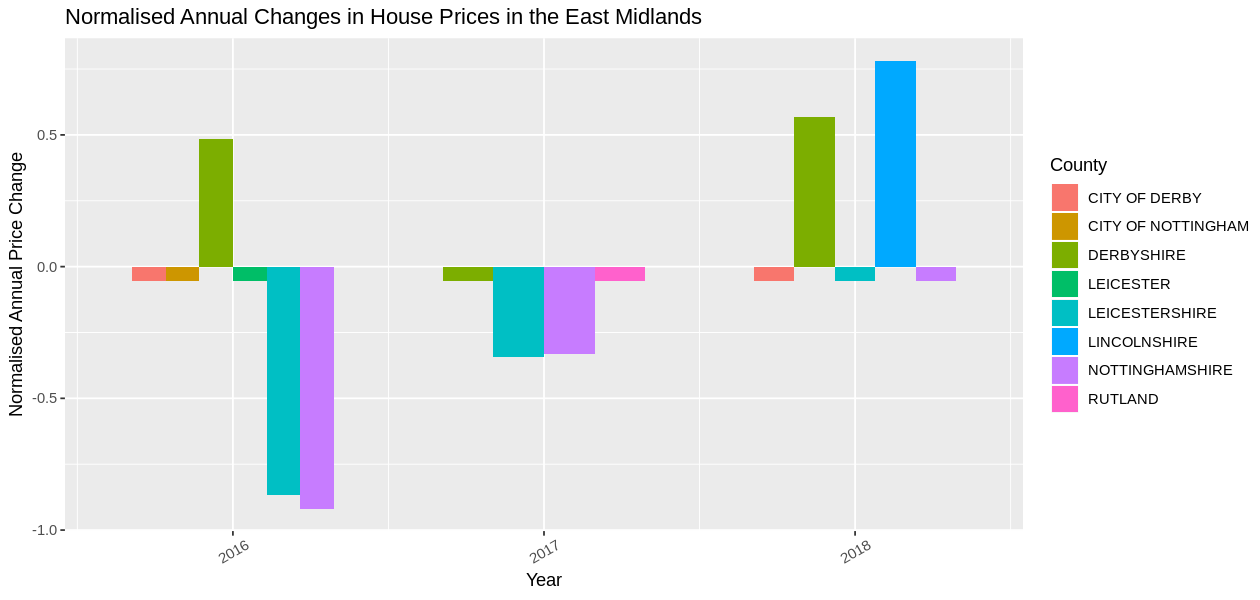

In [0]:
options(repr.plot.width = 10.5, repr.plot.height = 5)
plot_em_price_change_by_year <- ggplot(east_mids_annual_price_change[east_mids_annual_price_change$Year >= "2015-01-01", ], aes(x = Year, y = Normalised_Price_Change)) +
                            geom_col(aes(fill = County), position = "dodge", width = 0.65) +
                            scale_x_continuous(breaks = seq(2016, 2018, 1), limits = c(2015.6, 2018.4)) +
                            labs(x = "Year", y = "Normalised Annual Price Change", title = "Normalised Annual Changes in House Prices in the East Midlands") +
                            theme(axis.text.x = element_text(angle = 30, vjust = 0.6))
plot_em_price_change_by_year
options(repr.plot.width = 6, repr.plot.height = 4)

In [0]:
av_change_county <- east_mids_annual_price_change[east_mids_annual_price_change$Year >= "2016-01-01", ] %>%
                        group_by(County) %>%
                        summarise(Average_Price_Change = mean(Normalised_Price_Change))
av_change_county[order(av_change_county$Average_Price_Change), ]

County,Average_Price_Change
LEICESTERSHIRE,-0.19864443
NOTTINGHAMSHIRE,-0.19316855
CITY OF DERBY,-0.05309311
RUTLAND,-0.05309311
DERBYSHIRE,0.25740489
LINCOLNSHIRE,0.78173046


top_and_tail(local_summary_ppd)

In [0]:
recent_by_postcode <- local_summary_ppd %>%
    filter(Year == 2018) %>%
    group_by(Postcode, Month)

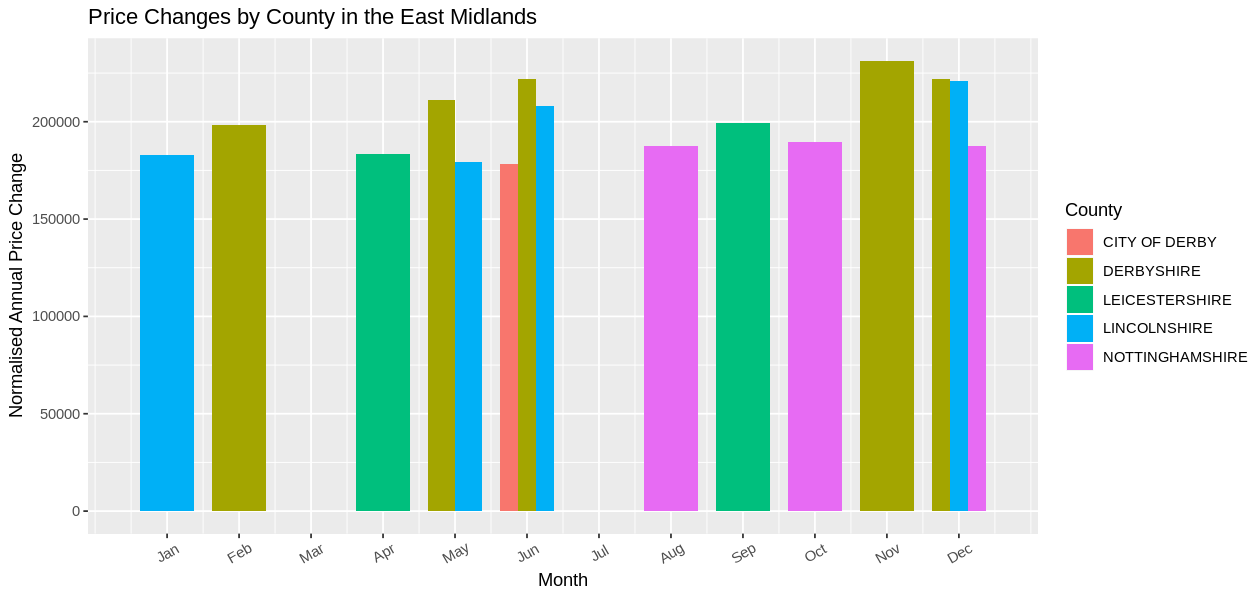

In [0]:
options(repr.plot.width = 10.5, repr.plot.height = 5)
p5 <- ggplot(recent_by_postcode, aes(x = Month, y = RM_Price)) +
                            geom_col(aes(fill = County), position = "dodge", width = 0.75) +
                            scale_x_continuous(breaks = seq(1, 12, 1), labels = month.abb[seq(1, 12, 1)], limits = c(0.5, 12.5)) +
                            labs(x = "Month", y = "Normalised Annual Price Change", title = "Price Changes by County in the East Midlands") +
                            theme(axis.text.x = element_text(angle = 30, vjust = 0.6))
p5
options(repr.plot.width = 6, repr.plot.height = 4)

To get an idea of where to buy, let's compute the year-on-year change in price and filter for postcodes which have higher than average price increases.  As the dataset goes back to 2009, we'll also weight the results to favour more recent years.

First we take a subset of the summarised local price paid data.

In [0]:
local_summary_ppd <- local_summary_ppd %>%
    select(County, Postcode, Year, Median_Price, RM_Price, Annual_Price_Change) %>%
    arrange(Postcode, Year)

local_summary_ppd

County,Postcode,Year,Median_Price,RM_Price,Annual_Price_Change
DERBYSHIRE,DE11 0FJ,2016,169950.0,180798.3,4368.0000
DERBYSHIRE,DE11 0LA,2004,212450.0,188299.2,2338.0000
DERBYSHIRE,DE11 7BN,2012,182497.5,195982.5,1341.3333
DERBYSHIRE,DE11 7GX,2004,193000.0,194832.5,2338.0000
DERBYSHIRE,DE11 7GX,2005,209000.0,202000.0,835.4167
DERBYSHIRE,DE11 8AU,2007,204000.0,200498.3,1505.2500
DERBYSHIRE,DE11 8FL,2007,188495.0,206163.3,1505.2500
LEICESTERSHIRE,DE11 8FZ,2016,209750.0,192246.7,4368.0000
LEICESTERSHIRE,DE11 8HA,2003,176995.0,192081.7,1335.3333
DERBYSHIRE,DE11 9GL,2014,225995.0,202398.2,2517.5000


Now we need to deal with missing years.  To do so, we will create a data.table which has the years 2009 to 2018 for each postcode in *local_summary_ppd*.  We will then do a *full_join* (from dplyr) with *local_summary_ppd*.  This will have the effect of inserting NAs for the previously missing year rows.

In [0]:
install.packages("data.table")
library(data.table)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Attaching package: ‘data.table’

The following object is masked from ‘package:reshape’:

    melt

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [0]:
padding <- setDT(local_summary_ppd)[, .SD[2009:2018], by = Postcode] %>% select_if(~!all(is.na(.)))
padding$Year <- rep(seq(2009, 2018, 1), length(unique(padding)))

In [0]:
local_summary_ppd <- full_join(padding, local_summary_ppd, by = c("Postcode", "Year"))
local_summary_ppd

Postcode,Year,County,Median_Price,RM_Price,Annual_Price_Change
DE11 0FJ,2009,NA,NA,NA,NA
DE11 0FJ,2010,NA,NA,NA,NA
DE11 0FJ,2011,NA,NA,NA,NA
DE11 0FJ,2012,NA,NA,NA,NA
DE11 0FJ,2013,NA,NA,NA,NA
DE11 0FJ,2014,NA,NA,NA,NA
DE11 0FJ,2015,NA,NA,NA,NA
DE11 0FJ,2016,DERBYSHIRE,169950.0,180798.3,4368.000
DE11 0FJ,2017,NA,NA,NA,NA
DE11 0FJ,2018,NA,NA,NA,NA


In [0]:
local_summary_ppd <- local_summary_ppd %>% 
  fill(County, Median_Price, RM_Price, Annual_Price_Change, .direction = "up")

Next we create two new columns, which are the difference in median price between years and the difference in mean price between years.

In [0]:
local_summary_ppd <- local_summary_ppd %>%
    group_by(Postcode, Year) %>%
    mutate(Diff_Median_Price = diff(c(Median_Price, 0))) %>%
    mutate(Diff_Mean_Price = diff(c(RM_Price, 0)))

local_summary_ppd

Postcode,Year,County,Median_Price,RM_Price,Annual_Price_Change,Diff_Median_Price,Diff_Mean_Price
DE11 0FJ,2009,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2010,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2011,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2012,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2013,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2014,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2015,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2016,DERBYSHIRE,169950.0,180798.3,4368.000,-169950.0,-180798.3
DE11 0FJ,2017,DERBYSHIRE,182497.5,195982.5,1341.333,-182497.5,-195982.5
DE11 0FJ,2018,DERBYSHIRE,182497.5,195982.5,1341.333,-182497.5,-195982.5


subset_local_ppd_increase <- local_summary_ppd %>%
            filter(Diff_Median_Price > 0, Diff_Mean_Price > 0)

In [0]:
#median_median_price_increase <- median(subset_local_ppd_increase$Diff_Median_Price)
#median_mean_price_increase <- median(subset_local_ppd_increase$Diff_Mean_Price)

In [0]:
#big_local_price_increase <- subset_local_ppd_increase %>%
#            filter(Diff_Median_Price > median_median_price_increase, Diff_Mean_Price > median_mean_price_increase)

T

Next we will create score by which to rank the outward postcodes by price increase potential.  For this we will multiply the change in median and mean prices by *(Year - 2008) /  5e5*.  This factor was chosen as a simple way to weight more recent years more heavily and has the effect of giving 2018 data a score twice as large as 2008 data.

In [0]:
local_summary_ppd <- mutate(local_summary_ppd,
       Median_Price_Score = (Year - 2008) * Diff_Median_Price / 2e5,
       Mean_Price_Score = (Year - 2008) * Diff_Mean_Price / 2e5,
       Combined_Score = Median_Price_Score * Mean_Price_Score / 10) %>%
       arrange(-Median_Price_Score, -Mean_Price_Score)

top_and_tail(local_summary_ppd)

# A tibble: 6 x 11
# Groups:   Postcode, Year [6]
  Postcode  Year County Median_Price RM_Price Annual_Price_Ch… Diff_Median_Pri…
  <fct>    <dbl> <fct>         <dbl>    <dbl>            <dbl>            <dbl>
1 DE3 0DQ   2001 CITY …       231950  201650              667           -231950
2 NG14 7PS  2002 NOTTI…       222500  204666.            1168.          -222500
3 LE67 4PE  2000 LEICE…       161950  172283.             167.          -161950
4 DE3 0UT   2001 DERBY…       170250  193290              667           -170250
5 LE67 1HL  2003 LEICE…       229995  193080             1335.          -229995
6 LE6 0AX   2002 LEICE…       191250  201332.            1168.          -191250
# … with 4 more variables: Diff_Mean_Price <dbl>, Median_Price_Score <dbl>,
#   Mean_Price_Score <dbl>, Combined_Score <dbl>
# A tibble: 6 x 11
# Groups:   Postcode, Year [6]
  Postcode  Year County Median_Price RM_Price Annual_Price_Ch… Diff_Median_Pri…
  <fct>    <dbl> <fct>         <dbl>    <dbl>          

In [0]:
write.csv(local_summary_ppd, file = "house_price_data.csv")

In [0]:
postcodes <- read_csv("https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv")

Parsed with column specification:
cols(
  id = col_double(),
  postcode = col_character(),
  latitude = col_double(),
  longitude = col_double()
)


In [0]:
postcodes <- postcodes[, c("postcode", "latitude", "longitude")]
names(postcodes) <- c("Postcode", "Latitude", "Longitude")
postcodes <- postcodes %>%
    filter((Latitude != 0) | (Longitude != 0))
top_and_tail(postcodes)

# A tibble: 6 x 3
  Postcode Latitude Longitude
  <chr>       <dbl>     <dbl>
1 AB10         57.1     -2.12
2 AB11         57.1     -2.09
3 AB12         57.1     -2.11
4 AB13         57.1     -2.24
5 AB14         57.1     -2.27
6 AB15         57.1     -2.17
# A tibble: 6 x 3
  Postcode Latitude Longitude
  <chr>       <dbl>     <dbl>
1 BD97         53.9    -1.84 
2 BD98         53.8    -1.78 
3 BD99         53.8    -1.77 
4 SL60         51.5    -0.715
5 CA99         54.9    -2.94 
6 IV99         57.5    -4.22 


In [0]:
local_summary_ppd <- left_join(local_summary_ppd, postcodes, by = "Postcode")

Warning message:
“Column `Postcode` joining factor and character vector, coercing into character vector”

In [0]:
datamap <- local_summary_ppd[, c("Postcode", "Combined_Score", "Latitude",  "Longitude")]
datamap

Postcode,Combined_Score,Latitude,Longitude
DE3 0DQ,5.729658,NA,NA
NG14 7PS,4.098433,NA,NA
LE67 4PE,4.464206,NA,NA
DE3 0UT,4.031184,NA,NA
LE67 1HL,2.775465,NA,NA
LE6 0AX,3.465421,NA,NA
LE17 4GJ,3.343205,NA,NA
LE17 4FD,3.512647,NA,NA
NG31 8UA,2.966507,NA,NA
NG24 2SU,2.620519,NA,NA


In [0]:
write.csv(datamap, file = "house_price_datamap.csv")

In [0]:
top_and_tail(local_ppd)

# A tibble: 6 x 11
  Price_GBP Date_of_Transfer    Postcode Property_Type Old_or_New Street
      <dbl> <dttm>              <chr>    <chr>         <chr>      <chr> 
1    165000 2000-05-18 00:00:00 DE23 4BA D             Y          PASTU…
2    190500 2000-12-20 00:00:00 DE23 3UD D             N          QUEEN…
3    245000 2000-07-13 00:00:00 LE14 3LL D             N          THE G…
4    172000 2000-11-27 00:00:00 LE9 3GU  D             N          HUNCO…
5    229500 2000-10-10 00:00:00 LE12 5LJ D             N          PASTU…
6    177495 2000-05-26 00:00:00 NG13 8TX D             Y          TREFO…
# … with 5 more variables: Locality <chr>, Town_City <chr>, District <chr>,
#   County <chr>, Outcode <chr>
# A tibble: 6 x 11
  Price_GBP Date_of_Transfer    Postcode Property_Type Old_or_New Street
      <dbl> <dttm>              <chr>    <chr>         <chr>      <chr> 
1    185000 2019-01-18 00:00:00 NG19 8JX D             N          LEY L…
2    165000 2019-01-04 00:00:00 NG8 1AL  S         

Let's go back to basics...

In [0]:
local_summary_ppd <- local_ppd %>%
    mutate(Year = strftime(Date_of_Transfer, format = "%Y"),
    Month = strftime(Date_of_Transfer, format = "%m")) %>%
    group_by(County, Postcode, Year, Month) %>%
    filter(n() > 5) %>%
    summarise(Median_Price = median(Price_GBP),
              Trimmed_Mean_Price = mean(Price_GBP, 0.1))
local_summary_ppd$County <- as.factor(local_summary_ppd$County)
local_summary_ppd$Postcode <- as.factor(local_summary_ppd$Postcode)
local_summary_ppd$Year <- as.numeric(local_summary_ppd$Year)
local_summary_ppd$Month <- as.numeric(local_summary_ppd$Month)
top_and_tail(local_summary_ppd)
str(local_summary_ppd)

# A tibble: 6 x 6
# Groups:   County, Postcode, Year [6]
  County        Postcode  Year Month Median_Price Trimmed_Mean_Price
  <fct>         <fct>    <dbl> <dbl>        <dbl>              <dbl>
1 CITY OF DERBY DE22 3XT  2018     6      165995             187424.
2 CITY OF DERBY DE22 4GW  2016     9      190995             198495 
3 CITY OF DERBY DE22 4JL  2015     6      180998.            185872.
4 CITY OF DERBY DE22 4NW  2016     6      184950             196379.
5 CITY OF DERBY DE23 3ZA  2006    10      198000             199107.
6 CITY OF DERBY DE3 0DQ   2001    10      231950             223321.
# A tibble: 6 x 6
# Groups:   County, Postcode, Year [6]
  County          Postcode  Year Month Median_Price Trimmed_Mean_Price
  <fct>           <fct>    <dbl> <dbl>        <dbl>              <dbl>
1 NOTTINGHAMSHIRE NG24 3UL  2012     6      179495             193246.
2 NOTTINGHAMSHIRE NG5 8RN   2014     6      245548.            235180 
3 NOTTINGHAMSHIRE NG5 8TY   2012     1      184975